In [21]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn 
from sklearn.model_selection import train_test_split

In [22]:
data_dir = '/Users/Shrey/Datasets/Sign-language-digits-dataset-2/'

In [23]:
X = np.load(data_dir + "X.npy")
Y = np.load(data_dir + "Y.npy")

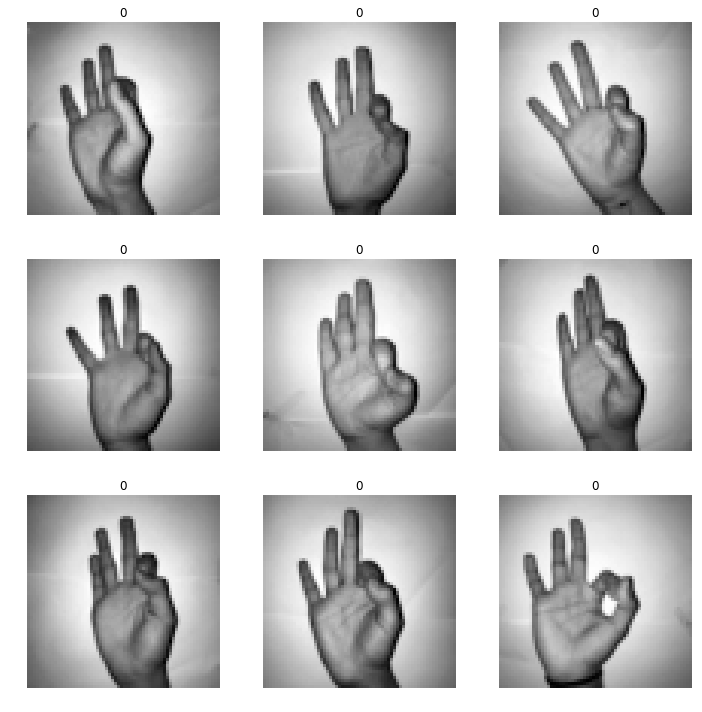

In [24]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.tight_layout()
    plt.imshow(X[i], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(Y[i].argmax())    
plt.show()

In [25]:
print("X: ", X.shape )
print("Y: ", Y.shape )

X:  (2062, 64, 64)
Y:  (2062, 10)


Image Label:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


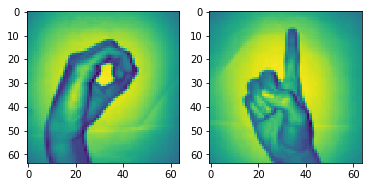

In [26]:
plt.subplot(1,2,1)
plt.imshow(X[260].reshape(64,64))
print("Image Label: ", Y[800])
plt.subplot(1,2,2)
plt.imshow(X[900].reshape(64,64))

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

In [28]:
X_train.shape

(1752, 64, 64)

# Training Model

In [29]:
import tensorflow as tf
import random as rn
from keras import backend as K

os.environ['PYTHONHASHSEED'] = '0'

SEED = 1
np.random.seed(SEED)
rn.seed(SEED)

In [30]:
img_rows , img_cols, img_channel = 64, 64, 1
target_size = (img_rows, img_cols)
target_dims = (img_rows, img_cols, img_channel) 
n_classes = 10
val_frac = 0.2
batch_size = 64

In [31]:
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

In [32]:
number_of_train, number_of_test

(1752, 310)

In [33]:
from keras.layers import Dropout, Flatten, Dense, Convolution2D, MaxPooling2D, Input, BatchNormalization
from keras.models import Sequential, Model 
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow import set_random_seed

In [34]:
def initialize_nn_seed(seed):
    np.random.seed(seed)
    rn.seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.set_random_seed(seed)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess) 

In [35]:
def create_model(seed):
    initialize_nn_seed(seed)    
    
    model = Sequential()
    model.add(Convolution2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(64, 64, 1)))
    model.add(Convolution2D(16, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(Convolution2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, kernel_size=(2, 2), strides=(1, 1), activation='relu'))
    model.add(Convolution2D(64, kernel_size=(2, 2), strides=(2, 2), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-3), metrics=["accuracy"])
    return model

In [36]:
def train_model(model): 
    epochs = 15 
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint("weights-best.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    annealer = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=10*batch_size,
        epochs=epochs,
        validation_data=(X_test, Y_test),
        callbacks=[early_stopping, checkpoint, annealer]
    )  
    model.load_weights("weights-best.hdf5")
    return history, model

In [37]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range = 0.1,
                             fill_mode="nearest")
        
train_generator = datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=SEED, subset="training")

In [38]:
model = create_model(seed=123)
history, model = train_model(model)

Epoch 1/15
640/640 [==============================] - 1147s 2s/step - loss: 1.2548 - acc: 0.5592 - val_loss: 0.2591 - val_acc: 0.9258
Epoch 2/15
640/640 [==============================] - 309s 483ms/step - loss: 0.4300 - acc: 0.8577 - val_loss: 0.1392 - val_acc: 0.9710
Epoch 3/15
640/640 [==============================] - 356s 557ms/step - loss: 0.2772 - acc: 0.9089 - val_loss: 0.0953 - val_acc: 0.9839
Epoch 4/15
640/640 [==============================] - 678s 1s/step - loss: 0.2117 - acc: 0.9312 - val_loss: 0.0658 - val_acc: 0.9774
Epoch 5/15
640/640 [==============================] - 394s 616ms/step - loss: 0.1742 - acc: 0.9430 - val_loss: 0.0686 - val_acc: 0.9806

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/15
640/640 [==============================] - 277s 433ms/step - loss: 0.1270 - acc: 0.9592 - val_loss: 0.0420 - val_acc: 0.9968
Epoch 7/15
640/640 [==============================] - 279s 436ms/step - loss: 0.1125 - acc: 0.9643 - val_los

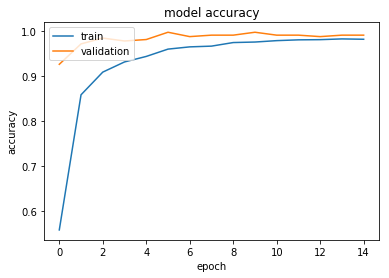

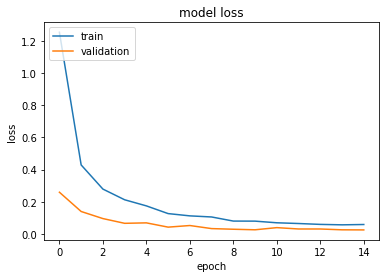

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
predicted_classes = model.predict_classes(X_test)
Y_true = Y_test.argmax(axis=1)

/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


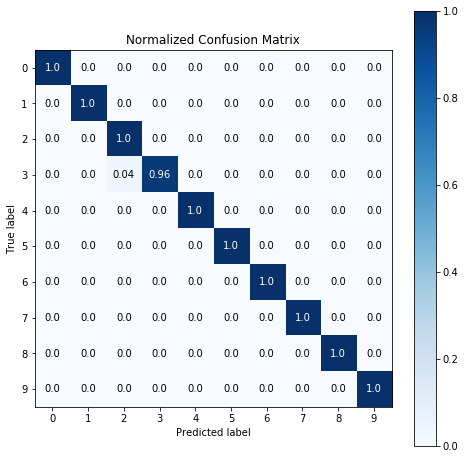

In [42]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(Y_true, predicted_classes, normalize=True, figsize=(8, 8))
plt.show()

In [43]:
correct = np.where(predicted_classes == Y_true)[0]
incorrect = np.where(predicted_classes != Y_true)[0]

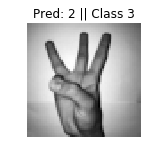

In [49]:
plt.figure(figsize=(8, 8))
for i, correct in enumerate(incorrect[:9]):
    plt.subplot(430+1+i)
    plt.imshow(X_test[correct].reshape(img_rows, img_cols), cmap='gray')
    plt.title("Pred: {} || Class {}".format(predicted_classes[correct], Y_true[correct]))
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_true, predicted_classes))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        27
          1       1.00      1.00      1.00        32
          2       0.98      1.00      0.99        42
          3       1.00      0.96      0.98        28
          4       1.00      1.00      1.00        24
          5       1.00      1.00      1.00        28
          6       1.00      1.00      1.00        30
          7       1.00      1.00      1.00        30
          8       1.00      1.00      1.00        34
          9       1.00      1.00      1.00        35

avg / total       1.00      1.00      1.00       310

